In [1]:
# import sys
# import os
# import subprocess
# import yaml
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from line_profiler import LineProfiler
import cProfile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Add the path to housing_app to the Python path, if it's not in the folder
# TODO: Adjust the path to match the local location of housing_app
# sys.path.append('/Users/k4robins/Devel/0_Thesis/housing_app')
# from housing_app.model.model import City
# Alternatively, if the housing_app is in the current folder, directly import it
from model.model import City

In [2]:
# Set parameter values and run simulation
# Do param sweep with gamma (exponential), A and price (quadratic together)
num_steps  = 40
parameters = {
            'run_notes': 'Debugging model.',
            'subfolder': None,
            'width': 50,
            'height':4,

            # FLAGS
            'center_city': False,     # Flag for city center in center if True, or bottom corner if False
            'random_init_age': False, # Flag for randomizing initial age. If False, all workers begin at age 0

            # LABOUR MARKET AND FIRM PARAMETERS
            'subsistence_wage': 40000.,  # psi
            'init_city_extent': 10.,  #  CUT OR CHANGE?
            'seed_population': 400,
            'init_wage_premium_ratio': 0.2, # 1.2, ###

            # PARAMETERS MOST LIKELY TO AFFECT SCALE
            'c': 300.0,                            ###
            'price_of_output': 10,                 ######
            'density':600,                         #####
            'A': 3000,                             ### 
            'alpha': 0.18,
            'beta':  0.75,
            'gamma': 0.12, ### reduced from .14
            'overhead': 1,
            'mult': 1.2,
            'adjN': 0.15,
            'adjk': 0.05,
            'adjn': 0.25,
            'adjF': 0.15,
            'adjw': 0.15, 
            #'dist': 1, 
            'init_agglomeration_population': 100000.0,
            'init_F': 100.0,
            'init_k': 100.0,
            'init_n': 100.0,

            # HOUSING AND MORTGAGE MARKET PARAMETERS
            'mortgage_period': 5.0,       # T, in years
            'working_periods': 40,        # in years
            'savings_rate': 0.3,
            'discount_rate': 0.07,        # 1/delta
            'r_margin': 0.01,
            'property_tax_rate': 0.04,     # tau, annual rate, was c
            'housing_services_share': 0.3, # a
            'maintenance_share': 0.2,      # b
            'max_mortgage_share': 0.9,
            'ability_to_carry_mortgage': 0.28,
            'wealth_sensitivity': 0.1,
        }

def run_simulation(num_steps, parameters):
    city = City(num_steps, **parameters)
    city.run_model()

    agent_out = city.datacollector.get_agent_vars_dataframe()
    model_out = city.datacollector.get_model_vars_dataframe()
    return agent_out, model_out


agent_out, model_out = run_simulation(num_steps, parameters)
# Turn on for timing
# cProfile.run("agent_out, model_out = run_simulation(num_steps, parameters)", sort='cumulative')


/var/folders/8x/m5kmbvj1165_088_hxrpv4740000gn/T/ipykernel_25273/1977606241.py:141: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


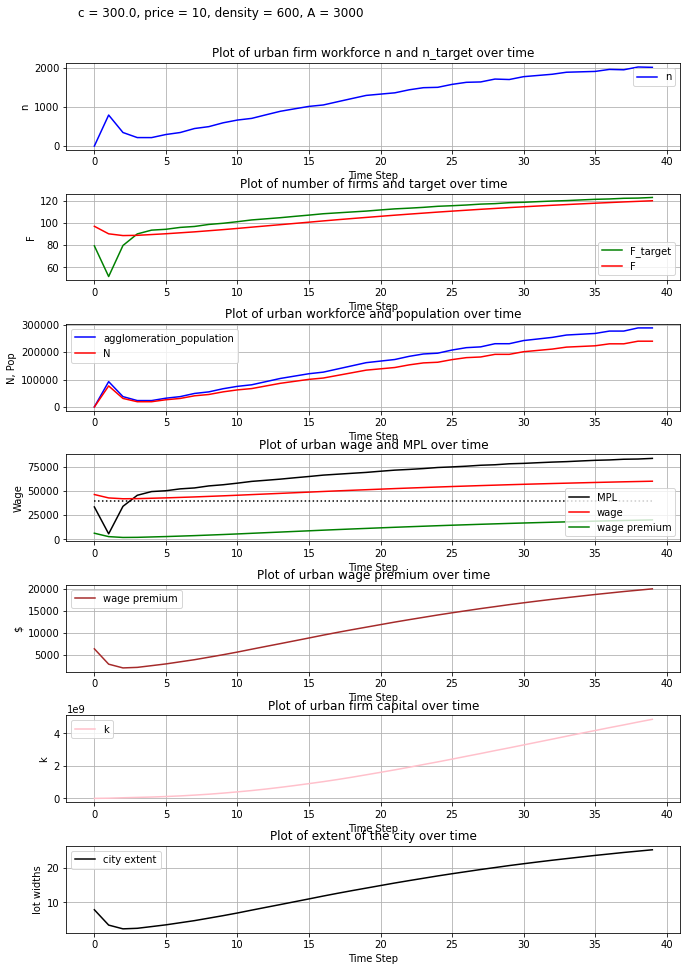

In [3]:
# Create a time array for the x-axis
time = np.arange(len(model_out['workers']))
# Create subplots with increased spacing
fig, axes = plt.subplots(7, 1, figsize=(11, 16)) # NUMBER OF PLOTS
# Adjust subplot spacing
fig.subplots_adjust(hspace=0.5)

# PRINT OUT PARAMETERS WITH PLOT
c_value = parameters['c'] #                    LIST PARAMETERS
price_of_output_value = parameters['price_of_output']
density_value = parameters['density']
A_value = parameters['A']

param_string = f'c = {c_value}, price = {price_of_output_value}, density = {density_value}, A = {A_value}'
plt.text(0.5, 0.92, param_string, transform=fig.transFigure, fontsize=12, ha='right')
 
# DESCRIBE PLOTS WANTED 
# Plot n
axes[0].plot(time, model_out['n'], label='n', color='blue')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('n')
axes[0].set_title('Plot of urban firm workforce n and n_target over time')
axes[0].grid(True)
axes[0].legend()


# axes[0].plot(time, model_out['n_target'], label='n_target', color='red')
# axes[0].set_xlabel('Time Step')
# axes[0].set_ylabel('n_target')
# #axes[0].set_title('Plot of urban firm workforce over time')
# axes[0].grid(True)
# axes[0].legend()

# Plot F ande F_target

axes[1].plot(time, model_out['F_target'], label='F_target', color='green')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('F_target')
#axes[1].set_title('Plot of target number of firms over time')
axes[1].grid(True)
axes[1].legend()

axes[1].plot(time, model_out['F'], label='F', color='red')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('F')
axes[1].set_title('Plot of number of firms and target over time')
axes[1].grid(True)
axes[1].legend()

# Plot N
axes[2].plot(time, model_out['agglomeration_population'], label='agglomeration_population', color='blue')
axes[2].plot(time, model_out['N'], label='N', color='red') 
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('N, Pop')
axes[2].set_title('Plot of urban workforce and population over time')
axes[2].grid(True)
axes[2].legend()


# # Plot Urban population
# axes[3].plot(time, model_out['agglomeration_population'], label='agglomeration_population', color='purple')
# axes[3].set_xlabel('Time Step')
# axes[3].set_ylabel('Agglomeration Population')
# axes[3].set_title('Plot of population over time')
# axes[3].grid(True)
# axes[3].legend()

# Plot w , MPL
axes[3].plot(time, model_out['MPL'], label='MPL', color='black')   
axes[3].plot(time, model_out['wage'], label='wage', color='red')
axes[3].plot(time, model_out['subsistence_wage'], ls = 'dotted', color='black')
axes[3].plot(time, model_out['wage_premium'], label='wage premium', color='green')
axes[3].set_xlabel('Time Step')
axes[3].set_ylabel('Wage')
axes[3].set_title('Plot of urban wage and MPL over time')
axes[3].grid(True)
axes[3].legend()


# # Plot y   ####   #3  HAD NO EFFECT
# # Y = parameters['price_of_output'] * model_out['A_F'] * (parameters['mult'] * model_out['N'] + parameters['seed_population']) ** parameters['gamma'] * model_out['k'] ** parameters['alpha_F'] * model_out['n'] ** parameters['beta_F']
# axes[4].plot(time, model_out['y'], label='firm output', color='orange')
# axes[4].set_xlabel('Time Step')
# axes[4].set_ylabel('')
# axes[4].set_title('Plot of firm output over time')
# axes[4].grid(True)
# axes[4].legend()

# Plot wage_premium    
axes[4].plot(time, model_out['wage_premium'], label='wage premium', color='brown')
axes[4].set_xlabel('Time Step')
axes[4].set_ylabel('$')
axes[4].set_title('Plot of urban wage premium over time')
axes[4].grid(True)
axes[4].legend()

# Plot k
axes[5].plot(time, model_out['k'], label='k', color='pink')
axes[5].set_xlabel('Time Step')
axes[5].set_ylabel('k')
axes[5].set_title('Plot of urban firm capital over time')
axes[5].grid(True)
axes[5].legend()

# Plot  dist
axes[6].plot(time, model_out['city_extent_calc'], label='city extent', color='black')
axes[6].set_xlabel('Time Step')
axes[6].set_ylabel('lot widths')
axes[6].set_title('Plot of extent of the city over time')
axes[6].grid(True)
axes[6].legend()


# # Plot  MPL
# axes[8].plot(time, model_out['MPL'], label='MPL', color='pink')
# axes[8].set_xlabel('Time Step')
# axes[8].set_ylabel('MPL')
# axes[8].set_title('Plot of MPL over time')
# axes[8].grid(True)
# axes[8].legend()


# # Plot MPL   ####  # 5 new  COMPLETELY MISSING!!
# axes[9].plot(time, model_out['MPL'], label='MPL', color='pink')
# #axes[9].plot(time, model_out['MPK'], label='MPK', color='blue')
# axes[9].set_xlabel('Time Step')
# axes[9].set_ylabel('MPL')
# axes[9].set_title('Plot of marginal product of labour over time')
# axes[9].grid(True)
# axes[9].legend()

# # Plot n_target  
# axes[10].plot(time, model_out['n_target'], label='MPL', color='red')
# axes[10].set_xlabel('Time Step')
# axes[10].set_ylabel('n_target')
# axes[10].set_title('Plot of n_target over time')
# axes[10].grid(True)
# axes[10].legend()


plt.tight_layout()

plt.show()



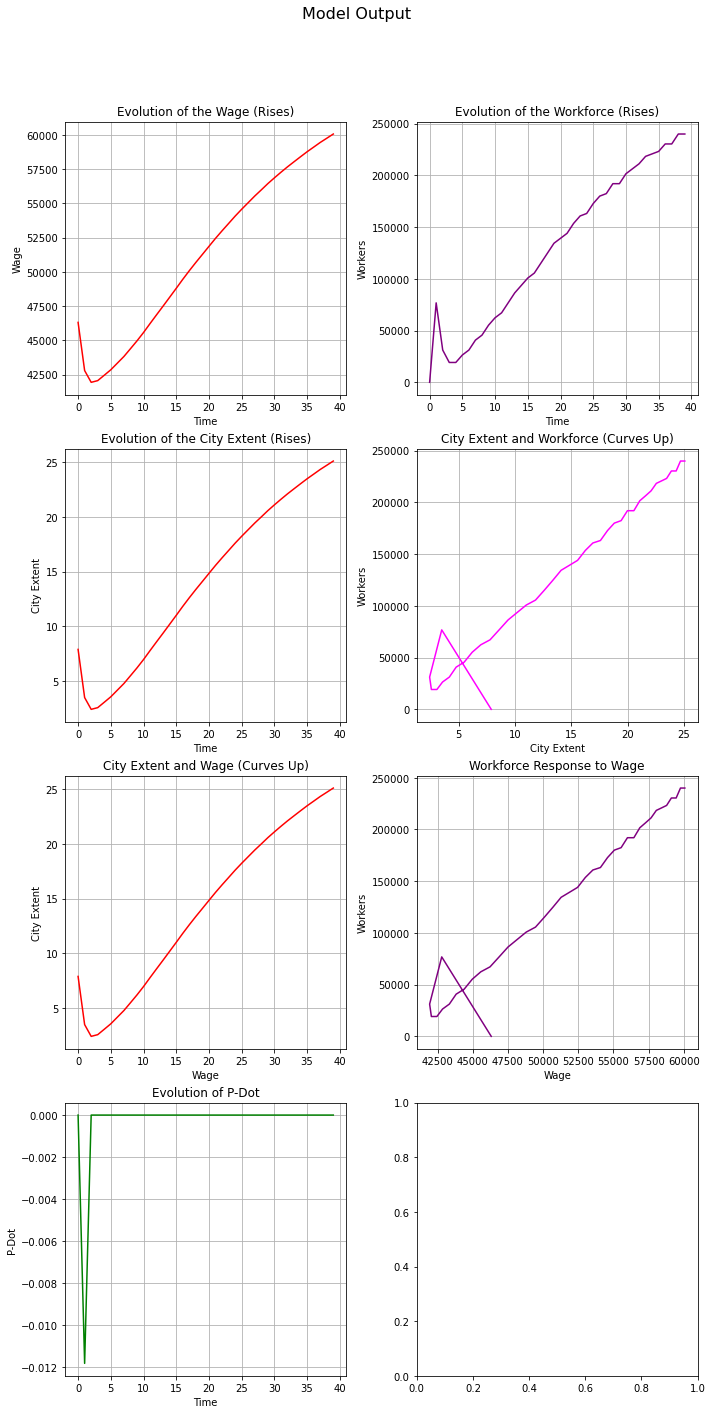

In [4]:
def plot_model_data(model_out):
    workers = np.array(model_out['workers'])
    wage_premium = np.array(model_out['wage_premium'])
    wage    = np.array(model_out['wage'])
    city_extent_calc = np.array(model_out['city_extent_calc'])
    p_dot   = np.array(model_out['p_dot'])
    time    = np.arange(len(workers))

#     # Extract additional variables from model_out
#     n = np.array(model_out['n'])
#     y = np.array(model_out['y'])
#     MPL = np.array(model_out['MPL'])
#     MPK = np.array(model_out['MPK'])
#     n_target = np.array(model_out['n_target'])
#     y_target = np.array(model_out['y_target'])
#     k_target = np.array(model_out['k_target'])
#     adj_f = np.array(model_out['adj_f'])
#     F_target = np.array(model_out['F_target'])
#     F_next = np.array(model_out['F_next'])
#     N_target_total = np.array(model_out['N_target_total'])
#     F_next_total = np.array(model_out['F_next_total'])
#     F = np.array(model_out['F'])
#     k = np.array(model_out['k'])

    fig, axes = plt.subplots(4, 2, figsize=(10, 20))
    fig.suptitle('Model Output', fontsize=16)

    # Subplot 0L: Evolution of the Wage  
    axes[0, 0].plot(time, wage, color='red')
    axes[0, 0].set_title('Evolution of the Wage (Rises)')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Wage')
    axes[0, 0].grid(True)

    # Subplot 0R: Evolution of the Workforce
    axes[0, 1].plot(time, workers, color='purple') 
    axes[0, 1].set_title('Evolution of the Workforce (Rises)')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Workers')
    axes[0, 1].grid(True)

    # Subplot 1L: Evolution of the City Extent
    axes[1,0].plot(time, city_extent_calc, color='red')
    axes[1,0].set_title('Evolution of the City Extent (Rises)')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('City Extent')
    axes[1,0].grid(True)

    # Subplot 1R: City Extent and Workforce  
    axes[1, 1].plot(city_extent_calc, workers, color='magenta')
    axes[1, 1].set_title('City Extent and Workforce (Curves Up)')
    axes[1, 1].set_xlabel('City Extent')
    axes[1, 1].set_ylabel('Workers')
    axes[1, 1].grid(True)              
    
    # Subplot 2L: City Extent and Wage
    axes[2, 0].plot(time, city_extent_calc, color='red')
    axes[2, 0].set_title('City Extent and Wage (Curves Up)')
    axes[2, 0].set_xlabel('Wage')
    axes[2, 0].set_ylabel('City Extent')
    axes[2, 0].grid(True)

    # Subplot 2R: Workforce Response to Wage
    axes[2, 1].plot(wage, workers, color='purple')
    axes[2, 1].set_title('Workforce Response to Wage')
    axes[2, 1].set_xlabel('Wage')
    axes[2, 1].set_ylabel('Workers')
    axes[2, 1].grid(True)

    # Subplot 3L: Evolution of P_Dot
    axes[3, 0].plot(time, p_dot, color='green')
    axes[3, 0].set_title('Evolution of P-Dot')
    axes[3, 0].set_xlabel('Time')
    axes[3, 0].set_ylabel('P-Dot')
    axes[3, 0].grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
plot_model_data(model_out)

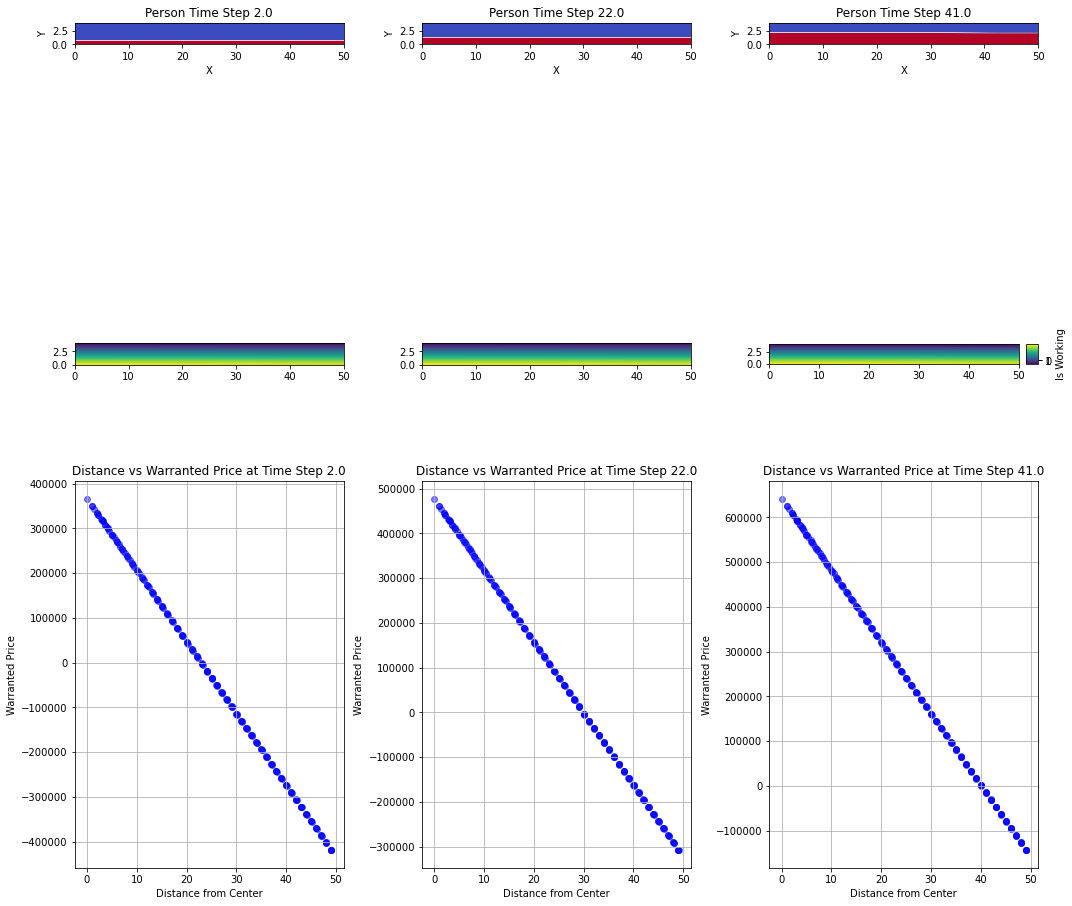

In [5]:
# Plot heatmaps
# Filter agent_out data for Person agents
person_df = agent_out.query("agent_type == 'Person'")
person_df = person_df.dropna(axis=1, how='all').reset_index(drop=True)
person_df = person_df.reset_index(drop=True)

# Filter agent_out data for Land agents
land_df = agent_out.query("agent_type == 'Land'")
land_df = land_df.dropna(axis=1, how='all').reset_index(drop=True)
land_df = land_df.reset_index(drop=True)

# Get the range of time steps
person_time_steps = person_df['time_step'].unique()
num_person_time_steps = len(person_time_steps)
person_middle_time_step = person_time_steps[num_person_time_steps // 2]

# Create subplots with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the subplots and time steps for Person data
for i, time_step in enumerate([person_time_steps[0], person_middle_time_step, person_time_steps[-1]]):
    person_agents = person_df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (person_df['x'].max() + 1, person_df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the 'is_working' values
    for index, row in person_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        is_working = row['is_working']
        heatmap[x, y] = is_working
    
    # Display the heatmap in the current subplot
    im = axs[0, i].imshow(heatmap, cmap='coolwarm', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]], vmin=0, vmax=1)
    axs[0, i].set_title(f'Person Time Step {time_step}')
    axs[0, i].set_xlabel('X')
    axs[0, i].set_ylabel('Y')
    axs[0, i].grid(False)

# Iterate over the subplots and time steps for Land data
for i, time_step in enumerate([person_time_steps[0], person_middle_time_step, person_time_steps[-1]]):
    land_agents = land_df.query("time_step == @time_step")
    
    # Create a grid to represent the space
    grid_size = (land_df['x'].max() + 1, land_df['y'].max() + 1)
    heatmap = np.zeros(grid_size)
    
    # Fill the heatmap with the values
    for index, row in land_agents.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        price = row['warranted_price']
        heatmap[x, y] = price
    
    # Display the heatmap in the current subplot
    im = axs[1, i].imshow(heatmap, cmap='viridis', origin='lower', extent=[0, grid_size[0], 0, grid_size[1]]) #, vmin=min_price, vmax=max_price)
    axs[1, i].grid(False)
    
    # Create scatter plot for distance from center vs warranted price
    scatter = axs[2, i].scatter(land_agents['distance_from_center'], land_agents['warranted_price'], c='blue', alpha=0.5)
    axs[2, i].set_title(f'Distance vs Warranted Price at Time Step {time_step}')
    axs[2, i].set_xlabel('Distance from Center')
    axs[2, i].set_ylabel('Warranted Price')
    axs[2, i].grid(True)
    
    # Set same min and max values for scatter plots
    # axs[2, i].set_ylim(min_price, max_price)

# Add a common colorbar
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, ticks=[0, 1])
cbar.set_label('Is Working')

plt.tight_layout()
plt.show()

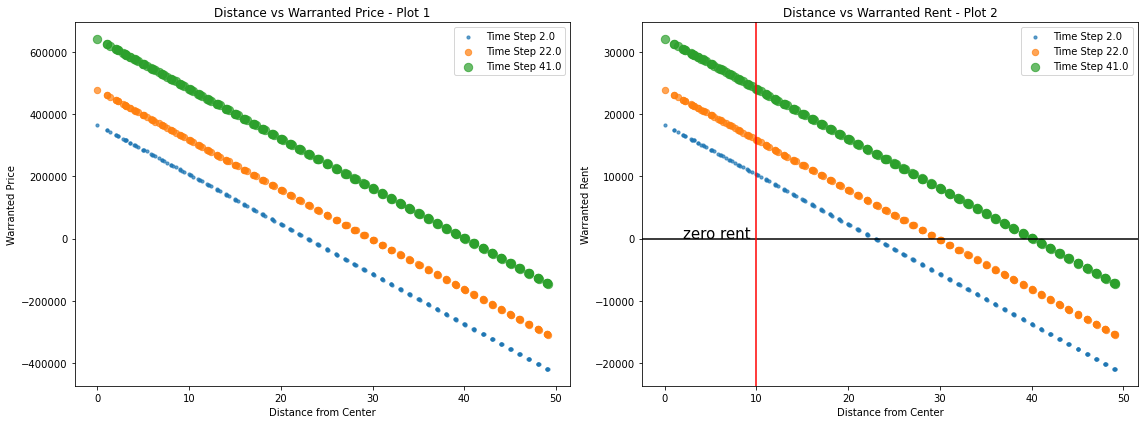

In [6]:
# Plot price vs distance at initilal, middle, and final time step
# Filter agent_out data for Land agents
df = agent_out.query("agent_type == 'Land'")
df = df.dropna(axis=1, how='all').reset_index(drop=True)
df = df.reset_index(drop=True)

# Get the range of time steps
time_steps = df['time_step'].unique()
middle_time_step = time_steps[len(time_steps) // 2]

# Calculate min and max dot sizes
min_dot_size = 10
max_dot_size = 70

# Create a scatter plot with three dots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create two subplots side by side

for ax_index, ax in enumerate(axs):
    # Create dots for the three selected time steps
    for i, time_step in enumerate([time_steps[0], middle_time_step, time_steps[-1]]):
        land_agents = df.query("time_step == @time_step")

        # Calculate dot size based on time step
        normalized_dot_size = (time_step - min(time_steps)) / (max(time_steps) - min(time_steps))
        dot_size = min_dot_size + (max_dot_size - min_dot_size) * normalized_dot_size

        # Determine which variable to plot based on subplot index
        if ax_index == 0:
            y_variable = 'warranted_price'
        else:
            y_variable = 'warranted_rent'

        # Create scatter plot for distance from center vs warranted_price or warranted_rent
        ax.scatter(land_agents['distance_from_center'], land_agents[y_variable], label=f'Time Step {time_step}', alpha=0.7, s=dot_size)

    # Set labels and title for each subplot
    ax.set_xlabel('Distance from Center')
    ax.set_ylabel(y_variable.replace('_', ' ').title())  # Format ylabel
    ax.set_title(f'Distance vs {y_variable.replace("_", " ").title()} - Plot {ax_index + 1}')
    ax.legend()

plt.tight_layout()
                 
# Add horizontal and vertical reference lines
plt.axhline(y = 0, xmin = 0., color ='black')# zero 
plt.axvline(x = 10, ymin = 0., color ='red')
plt.text(2, 6, r'zero rent', fontsize=15)

plt.show()

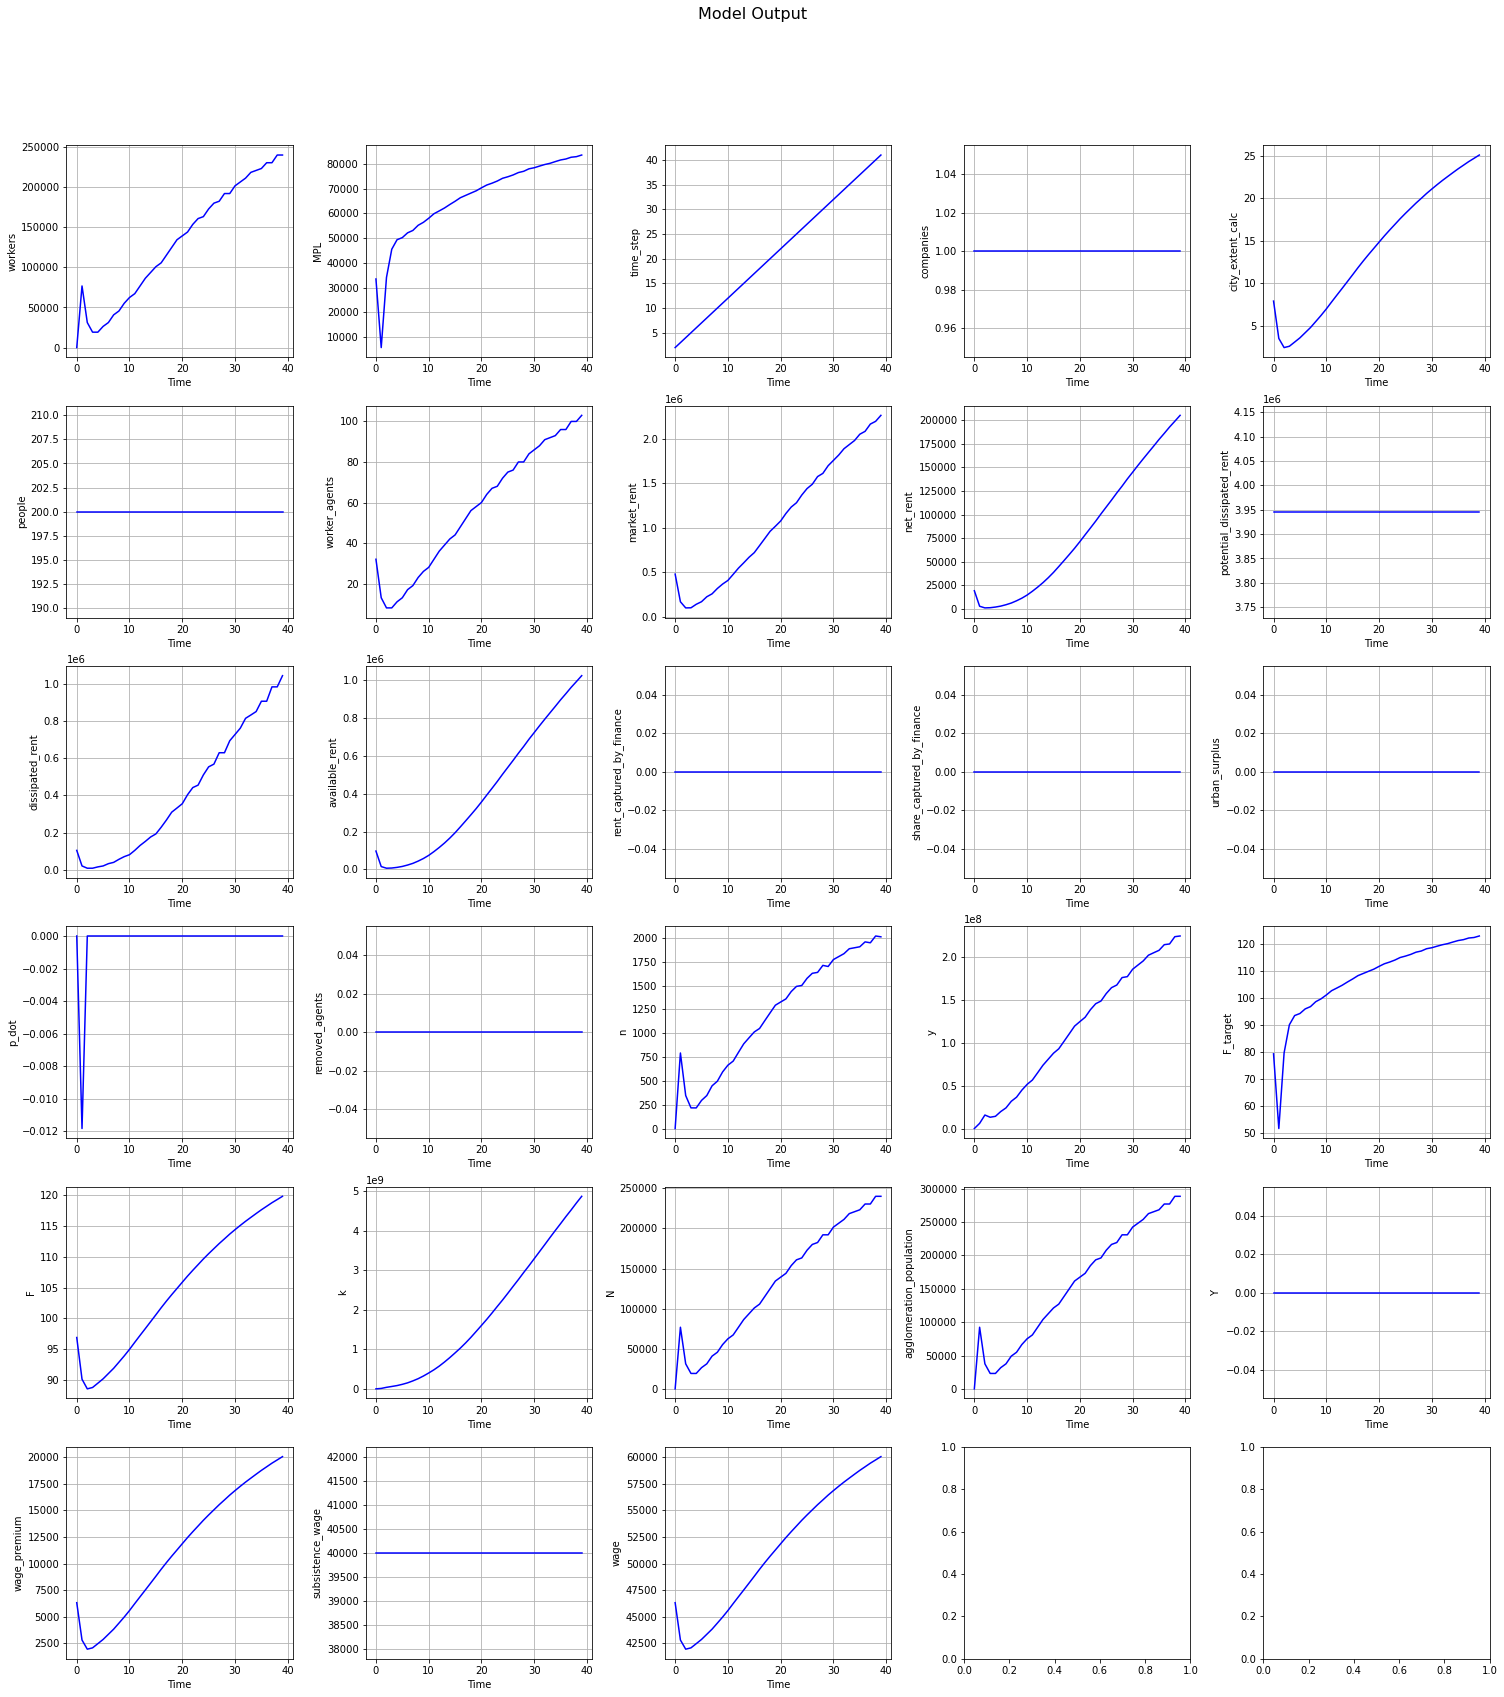

In [7]:
# Plot all model_out variables
def plot_all_model_out_keys(model_out):
    time = np.arange(len(model_out['workers']))

    # Set up the figure with subplots
    num_keys = len(model_out.keys())
    num_cols = 5  # Number of columns in the grid
    num_rows = (num_keys + num_cols - 1) // num_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 4 * num_rows))
    fig.suptitle('Model Output', fontsize=16)

    # Plot each model_out key
    model_out_keys = list(model_out.keys())
    for i, ax in enumerate(axes.ravel()):
        if i < len(model_out_keys):
            model_out_key = model_out_keys[i]
            variable = np.array(model_out[model_out_key])
            ax.plot(time, variable, color='blue')
            ax.set_xlabel('Time')
            ax.set_ylabel(model_out_key)
            ax.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
plot_all_model_out_keys(model_out)